<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Concatenate, Dot
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN, Input, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 20.3MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 10

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 390


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi ', 'hello  <eos>', '<sos> hello ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

- word2idx_inputs, max_input_len

In [8]:
# tokenizamos las entradas
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 142
Sentencia de entrada más larga: 4


In [9]:
input_sentences[0], input_sentences[1], input_sentences[2]

('hi ', 'hi ', 'hi ')

In [10]:
input_integer_seq[0], input_integer_seq[1], input_integer_seq[2]

([1], [1], [1])

- word2idx_outputs, max_out_len, num_words_output

In [11]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 158
Sentencia de salida más larga: 4


No vamos a limitar el tamaño de las setencias de entrada, ya que son pequeñas.

In [12]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
#max_input_len = 5
#max_out_len = 5

- encoder_input_sequences, decoder_output_sequences, decoder_targets

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [13]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 390
encoder_input_sequences shape: (390, 4)
decoder_input_sequences shape: (390, 4)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [14]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(390, 4, 159)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [15]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
#import os
#import gdown
#if os.access('gloveembedding.pkl', os.F_OK) is False:
#    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
#    output = 'gloveembedding.pkl'
#    gdown.download(url, output, quiet=False)
#else:
#    print("Los embeddings gloveembedding.pkl ya están descargados")

# fasttext
if os.access('crawl-300d-2M.vec.zip', os.F_OK) is False:
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
  !unzip crawl-300d-2M.vec.zip
else:
    print("Los embeddings fastext ya están descargados")

--2024-08-06 14:10:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.15, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G   131MB/s    in 14s     

2024-08-06 14:10:18 (106 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [16]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'crawl-300d-2M.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [17]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
#model_embeddings = GloveEmbeddings()

# fasttext de dimension 300
model_embeddings = FasttextEmbeddings()

In [18]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = len(word2idx_inputs) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [19]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(142, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [ ]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len, ))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, dropout=0.2, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len, ))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 4, 300)         │         42,600 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 4, 128)         │         20,352 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 128), (None,   │        219,648 │ embedding_2[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 4, 128),       │        131,584 │ embedding_3[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_2[0][1],          │
│                           │ 128)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4, 159)         │         20,511 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 434,695 (1.66 MB)

 Trainable params: 392,095 (1.50 MB)

 Non-trainable params: 42,600 (166.41 KB)

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

#plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=35,
    validation_split=0.2)

Epoch 1/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.3144 - loss: 4.9203 - val_accuracy: 0.4679 - val_loss: 4.0631
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4463 - loss: 3.4237 - val_accuracy: 0.4679 - val_loss: 2.1289
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4678 - loss: 2.0765 - val_accuracy: 0.7019 - val_loss: 1.9888
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6716 - loss: 1.8611 - val_accuracy: 0.7019 - val_loss: 1.8203
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6912 - loss: 1.7171 - val_accuracy: 0.7179 - val_loss: 1.7474
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6890 - loss: 1.6298 - val_accuracy: 0.7179 - val_loss: 1.6782
Epoch 7/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6931 - loss: 1.5915 - val_accuracy: 0.7179 - val_loss: 1.6439
Epoch 8/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6922 - loss: 1.5281 - val_accuracy: 0.7212 - 

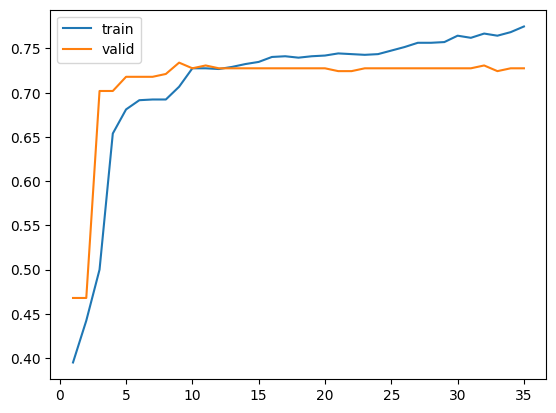

In [ ]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def answer_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = answer_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
-
Input: i am not
Response: what


In [ ]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [1]
Padding del vector: [[0 0 0 1]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Response: hi


#### Stack de LSTMs


In [ ]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len, ))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# stack lstm
encoder_lstm_1 = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
encoder_outputs_1, state_h_1, state_c_1 = encoder_lstm_1(encoder_inputs_x)
encoder_lstm_2 = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
encoder_outputs_2, state_h_2, state_c_2 = encoder_lstm_2(encoder_outputs_1)
encoder_lstm_3 = LSTM(n_units, dropout=0.2, return_state=True)
encoder_outputs, state_h_3, state_c_3 = encoder_lstm_3(encoder_outputs_2)
encoder_states = [state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3]

# define training decoder
decoder_inputs = Input(shape=(max_out_len, ))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs_1, _, _ = decoder_lstm(decoder_inputs_x, initial_state=[state_h_1, state_c_1])
decoder_lstm_2 = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs_2, _, _ = decoder_lstm_2(decoder_outputs_1, initial_state=[state_h_2, state_c_2])
decoder_lstm_3 = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs_3, _, _ = decoder_lstm_3(decoder_outputs_2, initial_state=[state_h_3, state_c_3])

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs_3)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_33            │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 4, 300)         │         42,600 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 4, 128)         │         20,352 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ [(None, 4, 128),       │        219,648 │ embedding_10[0][0]     │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_25 (LSTM)            │ [(None, 4, 128),       │        131,584 │ embedding_11[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_22[0][1],         │
│                           │ 128)]                  │                │ lstm_22[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ [(None, 4, 128),       │        131,584 │ lstm_22[0][0]          │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_26 (LSTM)            │ [(None, 4, 128),       │        131,584 │ lstm_25[0][0],         │
│                           │ (None, 128), (None,    │                │ lstm_23[0][1],         │
│                           │ 128)]                  │                │ lstm_23[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_24 (LSTM)            │ [(None, 128), (None,   │        131,584 │ lstm_23[0][0]          │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_27 (LSTM)            │ [(None, 4, 128),       │        131,584 │ lstm_26[0][0],         │
│                           │ (None, 128), (None,    │                │ lstm_24[0][1],         │
│                           │ 128)]                  │                │ lstm_24[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 4, 159)         │         20,511 │ lstm_27[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 961,031 (3.67 MB)

 Trainable params: 918,431 (3.50 MB)

 Non-trainable params: 42,600 (166.41 KB)

In [ ]:
# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

# define inference decoder
decoder_state_input_h_1 = Input(shape=(n_units,))
decoder_state_input_c_1 = Input(shape=(n_units,))
decoder_state_input_h_2 = Input(shape=(n_units,))
decoder_state_input_c_2 = Input(shape=(n_units,))
decoder_state_input_h_3 = Input(shape=(n_units,))
decoder_state_input_c_3 = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h_1, decoder_state_input_c_1,
                         decoder_state_input_h_2, decoder_state_input_c_2,
                         decoder_state_input_h_3, decoder_state_input_c_3]

# Entrada para una palabra de la secuencia de salida
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# Obtener las salidas del LSTM
decoder_outputs, state_h_1, state_c_1 = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs[:2]
)

decoder_outputs, state_h_2, state_c_2 = decoder_lstm_2(
    decoder_outputs, initial_state=decoder_states_inputs[2:4]
)

decoder_outputs, state_h_3, state_c_3 = decoder_lstm_3(
    decoder_outputs, initial_state=decoder_states_inputs[4:6]
)

decoder_states = [state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

decoder_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 1, 128)         │         20,352 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_34            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_35            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_25 (LSTM)            │ [(None, 1, 128),       │        131,584 │ embedding_11[1][0],    │
│                           │ (None, 128), (None,    │                │ input_layer_34[0][0],  │
│                           │ 128)]                  │                │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_36            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_26 (LSTM)            │ [(None, 1, 128),       │        131,584 │ lstm_25[1][0],         │
│                           │ (None, 128), (None,    │                │ input_layer_36[0][0],  │
│                           │ 128)]                  │                │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_27 (LSTM)            │ [(None, 1, 128),       │        131,584 │ lstm_26[1][0],         │
│                           │ (None, 128), (None,    │                │ input_layer_38[0][0],  │
│                           │ 128)]                  │                │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 159)         │         20,511 │ lstm_27[1][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 435,615 (1.66 MB)

 Trainable params: 435,615 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=35,
    validation_split=0.2)

Epoch 1/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.3258 - loss: 4.9553 - val_accuracy: 0.4679 - val_loss: 3.6015
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4346 - loss: 3.0285 - val_accuracy: 0.4679 - val_loss: 2.1128
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4433 - loss: 2.2121 - val_accuracy: 0.6667 - val_loss: 1.9584
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5519 - loss: 2.0035 - val_accuracy: 0.5962 - val_loss: 1.8513
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5893 - loss: 1.9207 - val_accuracy: 0.6571 - val_loss: 1.7865
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6436 - loss: 1.7655 - val_accuracy: 0.6506 - val_loss: 1.7666
Epoch 7/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6411 - loss: 1.6632 - val_accuracy: 0.6442 - val_loss: 1.7824
Epoch 8/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6374 - loss: 1.7075 - val_accuracy: 0.6667 - 

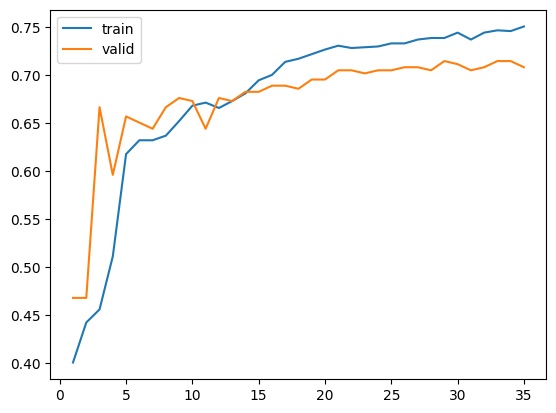

In [ ]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
def answer_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    # INFERENCE STEPS
    # Step 1: encode the entire input sequence and initialize the decoder with the internal states of the encoder.
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        # Steps of the inference phase
        # Part of Step 1.
        # Step 2: Pass <sos> token or token which you had specified as an input to the decoder.
        # Step 3: Run the decoder for one timestep with the internal states
        output_tokens, h_1, c_1, h_2, c_2, h_3, c_3 = decoder_model.predict([target_seq] + states_value)
        # Step 4: The output will be the probability for the next word. The word with the maximum probability will be selected.
        idx = np.argmax(output_tokens[0, 0, :])

        # Step 6: Repeat steps 3–5 until we generate <eos> token or hit the maximum length of the target sequence.
        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Step 5: Pass the maximum probability word as an input to the decoder in the next timestep and update the internal
        # states with the current time step
        # Actualizar los estados dada la última predicción
        states_value = [h_1, c_1, h_2, c_2, h_3, c_3]
        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx#----#

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = answer_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
-
Input: now
Response: i too


In [ ]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [1]
Padding del vector: [[0 0 0 1]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Response: hi


#### LSTM + attention layer

In [145]:
# Encoder
n_units = 256
encoder_inputs = Input(shape=(max_input_len, ))
encoder_embedding = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)(encoder_inputs)      # marcar como layer no entrenable

# stack lstm
encoder_lstm_1 = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm_1(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_embedding_output = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(n_units, dropout=0.2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)


# Mecanismo de Atención
attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder_outputs])

# Concatenar contexto y salidas del decodificador
decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

# Densa final para la predicción de la próxima palabra
output = Dense(num_words_output, activation='softmax')(decoder_combined_context)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_137           │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_138           │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_57 (Embedding)  │ (None, 4, 300)         │         42,600 │ input_layer_137[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_58 (Embedding)  │ (None, 4, 256)         │         40,704 │ input_layer_138[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_160 (LSTM)           │ [(None, 4, 256),       │        570,368 │ embedding_57[0][0]     │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_161 (LSTM)           │ [(None, 4, 256),       │        525,312 │ embedding_58[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_160[0][1],        │
│                           │ 256)]                  │                │ lstm_160[0][2]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_78 (Dot)              │ (None, 4, 4)           │              0 │ lstm_161[0][0],        │
│                           │                        │                │ lstm_160[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_34             │ (None, 4, 4)           │              0 │ dot_78[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_79 (Dot)              │ (None, 4, 256)         │              0 │ activation_34[0][0],   │
│                           │                        │                │ lstm_160[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_34            │ (None, 4, 512)         │              0 │ dot_79[0][0],          │
│ (Concatenate)             │                        │                │ lstm_161[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 4, 159)         │         81,567 │ concatenate_34[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,260,551 (4.81 MB)

 Trainable params: 1,217,951 (4.65 MB)

 Non-trainable params: 42,600 (166.41 KB)

In [146]:
# Modelo de Inferencia del Encoder
# Crear el modelo del encoder
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])


# Modelo de inferencia Decoder
# Entradas para los estados ocultos y celdas del decodificador
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# Entrada para una palabra de la secuencia de salida
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)
# Obtener las salidas del LSTM
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs
)

# Recalcular la atención
attn_out_inf = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attn_out_inf = Activation('softmax')(attn_out_inf)
context_inf = Dot(axes=[2, 1])([attn_out_inf, encoder_outputs])
# Concatenar contexto y salida del LSTM
decoder_combined_context_inf = Concatenate(axis=-1)([context_inf, decoder_outputs])
# Predicción final
decoder_outputs_inf = Dense(num_words_output, activation='softmax')(decoder_combined_context_inf)
# Modelo de inferencia del decodificador
decoder_model = Model(
    [decoder_inputs_single, encoder_outputs, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf, state_h, state_c]
)

In [147]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=35,
    validation_split=0.2)

Epoch 1/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.3300 - loss: 4.7345 - val_accuracy: 0.4679 - val_loss: 2.5371
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4868 - loss: 2.1911 - val_accuracy: 0.6827 - val_loss: 1.9833
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6687 - loss: 1.7727 - val_accuracy: 0.7115 - val_loss: 1.7983
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7002 - loss: 1.5405 - val_accuracy: 0.7179 - val_loss: 1.6873
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6910 - loss: 1.5031 - val_accuracy: 0.7372 - val_loss: 1.6469
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7348 - loss: 1.4118 - val_accuracy: 0.7308 - val_loss: 1.6434
Epoch 7/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7392 - loss: 1.3342 - val_accuracy: 0.7276 - val_loss: 1.6598
Epoch 8/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7438 - loss: 1.2937 - val_accuracy: 0.7276 - v

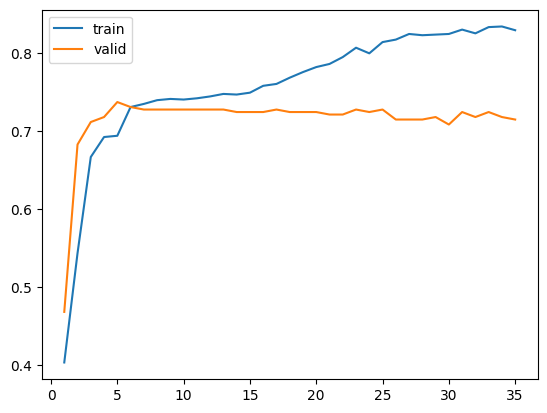

In [148]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [149]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [150]:
def answer_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    # INFERENCE STEPS
    # Step 1: encode the entire input sequence and initialize the decoder with the internal states of the encoder.
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        # Steps of the inference phase
        # Part of Step 1.
        # Step 2: Pass <sos> token or token which you had specified as an input to the decoder.
        # Step 3: Run the decoder for one timestep with the internal states
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_outputs] + states_value)
        # Step 4: The output will be the probability for the next word. The word with the maximum probability will be selected.
        idx = np.argmax(output_tokens[0, 0, :])

        # Step 6: Repeat steps 3–5 until we generate <eos> token or hit the maximum length of the target sequence.
        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Step 5: Pass the maximum probability word as an input to the decoder in the next timestep and update the internal
        # states with the current time step
        # Actualizar los estados dada la última predicción
        states_value = [h, c]
        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx#----#

    return ' '.join(output_sentence)

In [151]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = answer_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-
Input: i am not
Response: hobbie hobbie 4 4


In [152]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [1]
Padding del vector: [[0 0 0 1]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Response: in <sos> <sos> <sos>
